In [190]:
import pandas as pd
import numpy as np

In [191]:
data = pd.read_csv('/Users/haixiangliu/Documents/水质数据及代码模型/water_clean_data.csv')

In [192]:
data.columns = ['datetime','water_level','do','miss','input_wind_throughput','input_wind_openness','ts','input_water_cod','output_water_cod','input_water_ammonia','output_water_ammonia','input_water_ph','output_water_phosphorus','input_water_ss','output_water_ss']

In [193]:
data[['input_wind_throughput','input_wind_openness','input_water_cod','output_water_cod','output_water_ammonia','input_water_ss','output_water_ss']]=data[['input_wind_throughput','input_wind_openness','input_water_cod','output_water_cod','output_water_ammonia','input_water_ss','output_water_ss']].astype(float)

In [194]:
data['year'] = pd.to_datetime(data['datetime']).dt.year
data['month'] = pd.to_datetime(data['datetime']).dt.month
data['weekofyear'] = pd.to_datetime(data['datetime']).dt.weekofyear
data['hour'] = pd.to_datetime(data['datetime']).dt.hour
data[['year','month','weekofyear','hour']]= data[['year','month','weekofyear','hour']].astype(float)


In [195]:
rolling_features_input_cols = ['do', 'miss', 'input_wind_throughput', 'input_wind_openness',
                    'input_water_cod', 'output_water_cod', 'input_water_ammonia', 
                    'output_water_ammonia', 'input_water_ph', 'output_water_phosphorus', 
                    'input_water_ss', 'output_water_ss']
lags = [3, 7, 14, 30]

In [196]:
data_basic=data.sort_values(by=['datetime'])
data=data.sort_values(by=['datetime'])

In [197]:
#均值
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingmean_'+str(lag_n)]=data[col_name].rolling(window=lag_n).mean()

water_rollingmean=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingmean' in s)]

In [198]:
#最小值
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingmin_'+str(lag_n)]=data[col_name].rolling(window=lag_n).min()
water_rollingmin=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingmin' in s)]

In [199]:
#最大值
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingmax_'+str(lag_n)]=data[col_name].rolling(window=lag_n).max()
water_rollingmax=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingmax' in s)]

In [200]:
#标准差
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingstd_'+str(lag_n)]=data[col_name].rolling(window=lag_n).std()
water_rollingstd=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingstd' in s)]

In [201]:
#初值-均值
lags = [3,7]
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingdiff_'+str(lag_n)]=data[col_name]-data[col_name].rolling(window=lag_n).mean()
water_rollingdiff=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingdiff' in s)]

In [202]:
data_all = pd.merge(data,water_rollingmean,on=['ts'])\
                .merge(water_rollingmin,on=['ts'])\
                .merge(water_rollingmax,on=['ts'])\
                .merge(water_rollingstd,on=['ts'])\
                .merge(water_rollingdiff,on=['ts'])

In [203]:
data_all.head()

,datetime,water_level,do,miss,input_wind_throughput,input_wind_openness,ts,input_water_cod,output_water_cod,input_water_ammonia,...,input_wind_throughput_rollingdiff_7,input_wind_openness_rollingdiff_7,input_water_cod_rollingdiff_7,output_water_cod_rollingdiff_7,input_water_ammonia_rollingdiff_7,output_water_ammonia_rollingdiff_7,input_water_ph_rollingdiff_7,output_water_phosphorus_rollingdiff_7,input_water_ss_rollingdiff_7,output_water_ss_rollingdiff_7
0,2010-07-10 16:00:00,5.52,2.3,137.0,0.0,0.0,1.278745e+09,214.0,24.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-10 18:00:00,4.45,1.9,142.0,0.0,0.0,1.278752e+09,292.0,22.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-10 20:00:00,4.46,1.4,117.0,0.0,0.0,1.278760e+09,269.0,22.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-07-10 22:00:00,5.23,3.8,1463.0,5786.0,100.0,1.278767e+09,242.0,24.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-07-11 04:00:00,5.00,3.3,1490.0,5881.0,100.0,1.278788e+09,324.0,24.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
a=[]
for i in data_all['output_water_cod']:
    a.append(i)
a=a[5:34035]
data_all_label = data_all.drop([34031,34032,34033,34030,34034])
data_all_label['label_5']=a

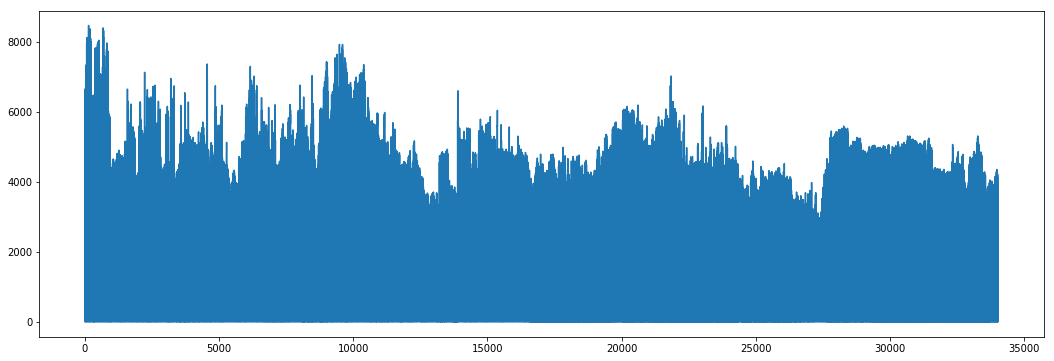

In [182]:
plt.plot(data_all_label['input_wind_throughput'])

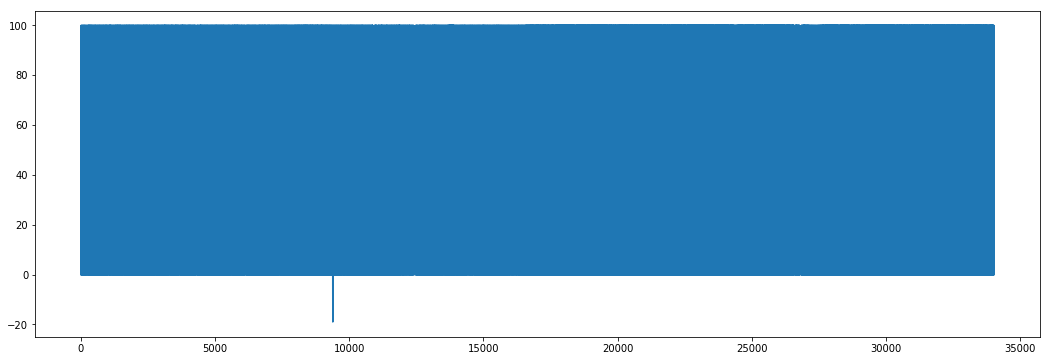

In [166]:
plt.plot(data_all_label['input_wind_openness'])

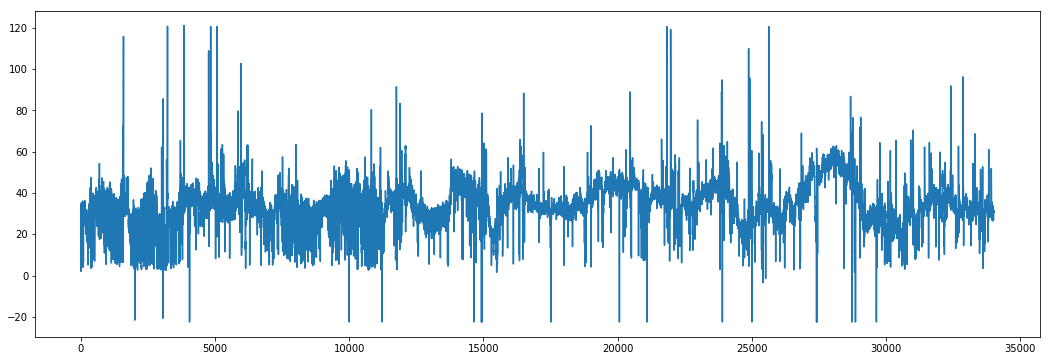

In [153]:
plt.plot(data_all_label['input_water_ammonia'])

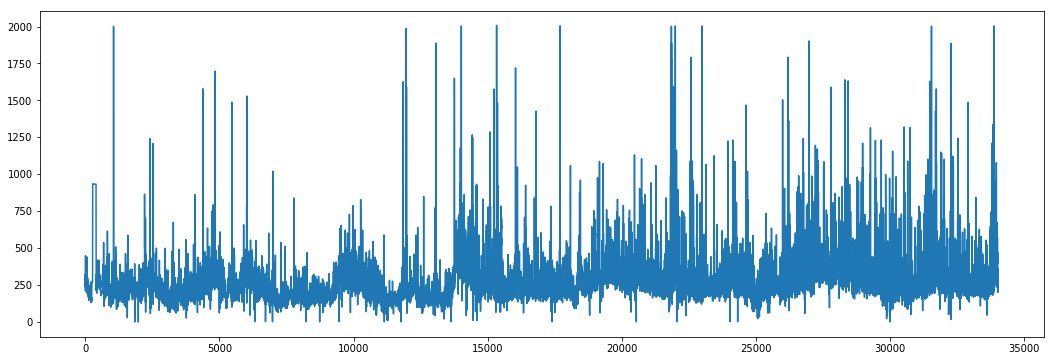

In [159]:
plt.plot(data_all_label['input_water_cod'])

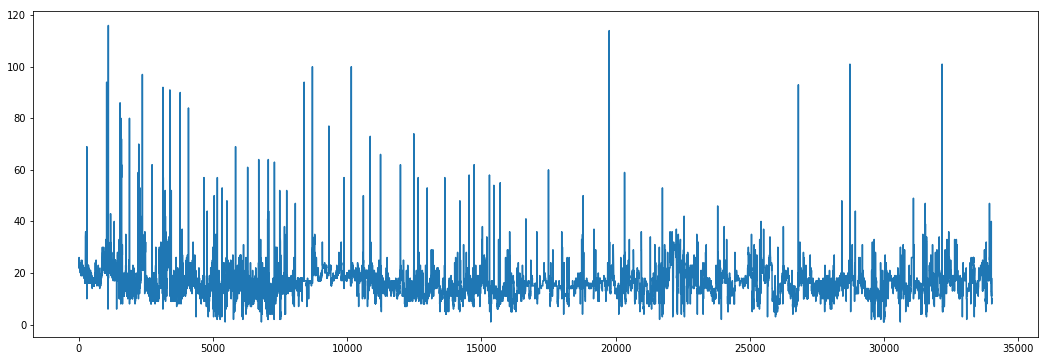

In [177]:
plt.plot(data_all_label['output_water_cod'])


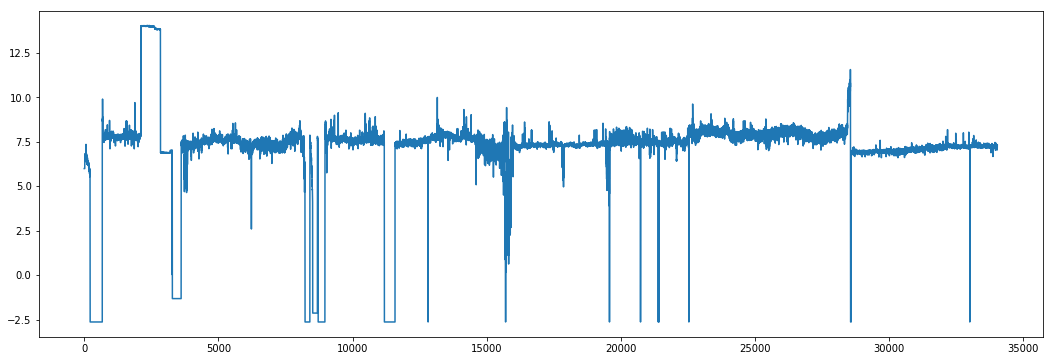

In [161]:
plt.plot(data_all_label['input_water_ph'])

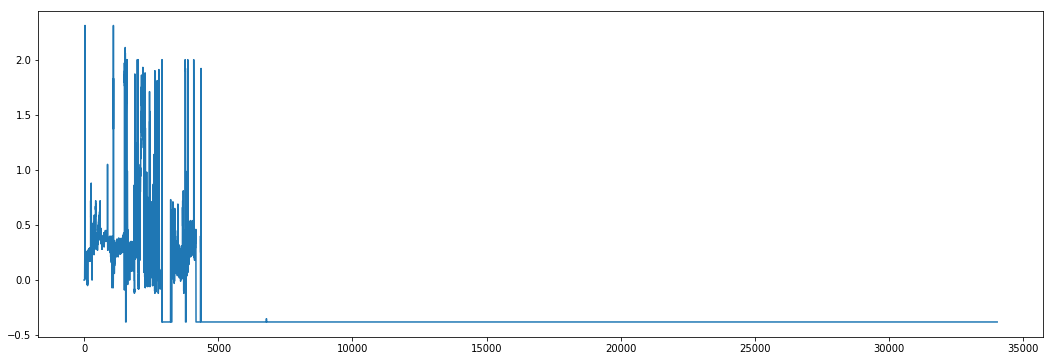

In [163]:
plt.plot(data_all_label['output_water_phosphorus'])

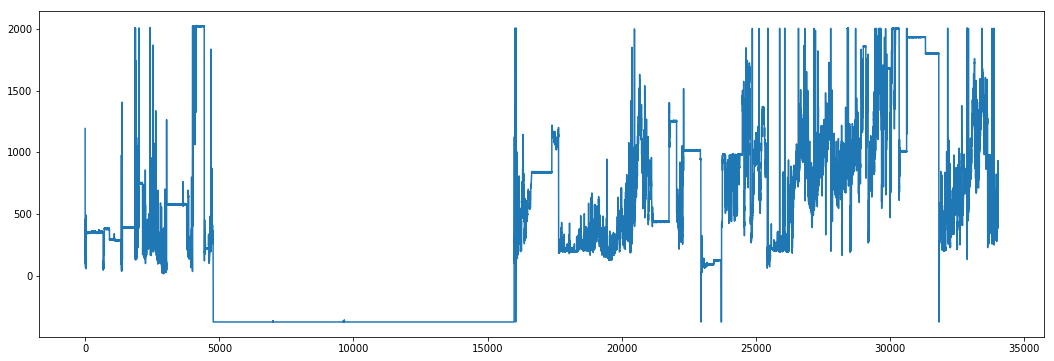

In [164]:
plt.plot(data_all_label['input_water_ss'])

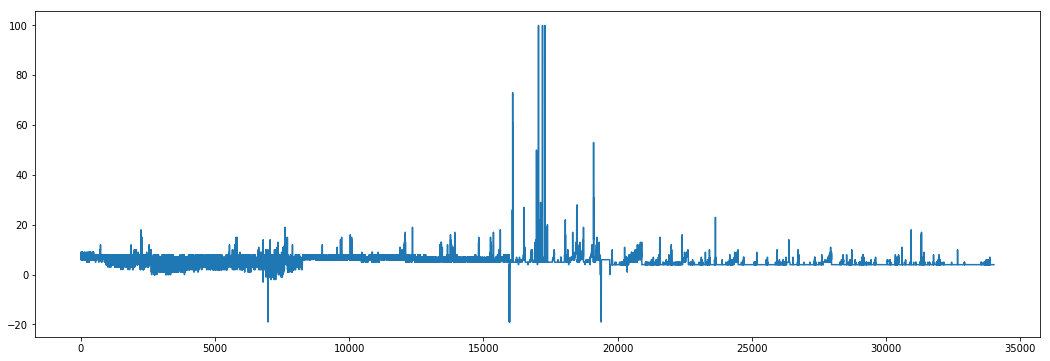

In [165]:
plt.plot(data_all_label['output_water_ss'])

In [205]:
train = data_all_label.loc[data_all_label['datetime']<"2016-01-01 00:00:00"]
test = data_all_label.loc[data_all_label['datetime']> "2015-12-31 23:59:59"]

In [206]:
train.shape,test.shape

((25442, 236), (8588, 236))

In [207]:
excluded_cols = ['datetime', 'ts', 'output_water_cod','label_5']
rolling_features = [col for col in data_all.columns if "_rolling" in col]
basic_features = [col for col in data_all.columns if col not in rolling_features + excluded_cols]

In [208]:
rollingmean_features = [col for col in data_all.columns if "_rollingmean_" in col]
rollingmax_features = [col for col in data_all.columns if "_rollingmax_" in col]
rollingmin_features = [col for col in data_all.columns if "_rollingmin_" in col]
rollingdiff_features = [col for col in data_all.columns if "_rollingdiff_" in col]
rollingstd_features = [col for col in data_all.columns if "_rollingstd_" in col]
features_basic=basic_features+rollingmean_features+rollingstd_features+rollingdiff_features
#+rollingmax_features+rollingmin_features+rollingmean_features+

In [209]:
len(features_basic)

136

In [210]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import Normalizer

In [211]:
pipe = Pipeline([('imputer',Imputer()),
                   # ('nor',Normalizer(norm='l2')),  #正则化
                    ('sc', StandardScaler()),   #标准化           
                   # ('pca', PCA(n_components=50)),
                    ('rf', RandomForestRegressor(n_estimators=100))    
                    #('xgbr',XGBRegressor(n_estimators=100))
                     #('dt',DecisionTreeRegressor(max_features=50))
                    ])
model = pipe.fit(train[features_basic],train['label_5'])

In [212]:
predictions = model.predict(train[features_basic])

In [213]:
mean_squared_error(train['label_5'],predictions)

2.1466924259099125

In [214]:
predictions_test = model.predict(test[features_basic])

In [215]:
mean_squared_error(test['label_5'],predictions_test)

18.59027786446204

In [216]:
%matplotlib inline 
import matplotlib.pyplot as plt

In [217]:
predictions= predictions[0:500]
train_label=[]
num=0
for i in train['label_5'].head(500).astype(float):
     train_label.append(i)

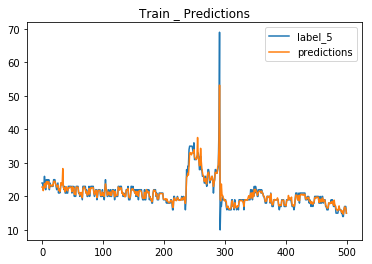

In [218]:
plt.plot(train_label,label='label_5')
plt.plot(predictions,label='predictions')
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.title('Train _ Predictions')
plt.legend()

In [219]:
predictions_label = predictions_test[0:500]
test_label=[]
num=0
for i in test['label_5'].head(500).astype(float):
     test_label.append(i)

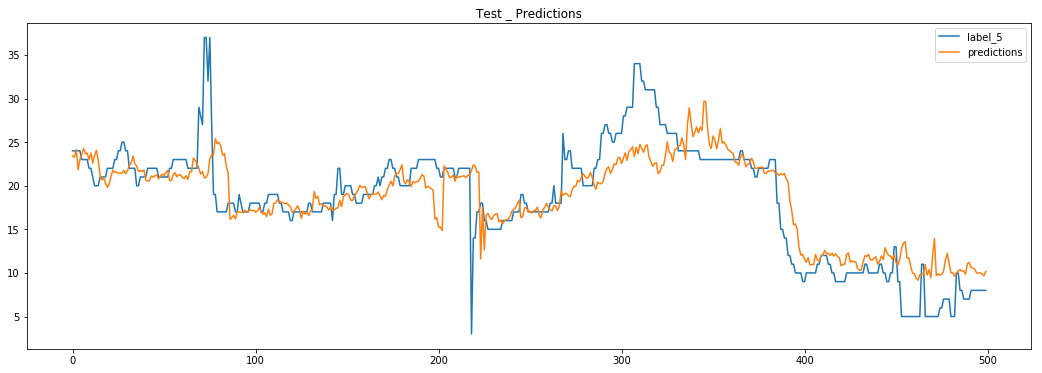

In [220]:
#print('Mean Squared Error (RMSE) -- Train : '+str(mean_squared_error(train['label_5'],predictions)))
#print('Mean Squared Error (RMSE) -- Test : '+str(mean_squared_error(test['label_5'],predictions_test)))
plt.plot(test_label,label='label_5')
plt.plot(predictions_label,label='predictions')
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.title('Test _ Predictions')
plt.legend()

In [78]:
from sklearn.model_selection import cross_val_score 

In [ ]:
print(cross_val_score(model,train[features_basic],train['label_5'],cv=5))